In [ ]:
!pip install ucimlrepo

In [ ]:
# Importar librerías que vamos a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Para validación y selección de modelos
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Para cargar datos desde UCI ML Repository
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import accuracy_score, classification_report

print("Setup completo!")

Setup completo!


In [ ]:
# Cargar dataset de estudiantes desde UCI
student_data = fetch_ucirepo(id=697)

# Preparar datos
X = student_data.data.features
y = student_data.data.targets

print("Dataset: Student Dropout and Academic Success")
print(f"Estudiantes: {X.shape[0]}, Características: {X.shape[1]}")
print(f"Objetivo: Predecir {len(y.columns)} variable(s)")

# Explorar variable objetivo
target_col = y.columns[0]  # Primera columna objetivo
y_series = y[target_col]
print(f"\nVariable objetivo: {target_col}")

# Mapear valores para mejor interpretación
target_mapping = {'Dropout' : 0, 'Enrolled' : 1, 'Graduate' : 2}
y_mapped = y_series.map(target_mapping)

# Distribución de clases
print("\nDistribución de resultados académicos:")
value_counts = y_mapped.value_counts()
for outcome, count in value_counts.items():
    percentage = (count / len(y_mapped)) * 100
    print(f"  {outcome}: {count} estudiantes ({percentage:.1f}%)")

# Ver algunas características
print(f"\nPrimeras características:")
print(X.columns.tolist()[:10], "...")

# Estadísticas básicas
print(f"\nAge at enrollment:")
if 'Age at enrollment' in X.columns:
    age_col = X['Age at enrollment']
    print(f"  Promedio: {age_col.mean():.1f} años")
    print(f"  Rango: {age_col.min():.0f}-{age_col.max():.0f} años")

Dataset: Student Dropout and Academic Success
Estudiantes: 4424, Características: 36
Objetivo: Predecir 1 variable(s)

Variable objetivo: Target

Distribución de resultados académicos:
  2: 2209 estudiantes (49.9%)
  0: 1421 estudiantes (32.1%)
  1: 794 estudiantes (17.9%)

Primeras características:
['Marital Status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification"] ...

Age at enrollment:
  Promedio: 23.3 años
  Rango: 17-70 años


In [ ]:
# Preparar variable objetivo como serie simple
# Convertir strings a números para sklearn
target_mapping = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}
reverse_mapping = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}

# Si y_series contiene strings, convertir a números
if y_series.dtype == 'object':
    y_target = y_series.map(reverse_mapping)
else:
    y_target = y_series

X_features = X       # Features del dataset

print("Datos preparados para validación:")
print(f"X shape: {X_features.shape}")
print(f"y shape: {y_target.shape}")
print(f"Clases únicas: {sorted(y_target.unique())}")
print(f"Mapeo: {target_mapping}")

Datos preparados para validación:
X shape: (4424, 36)
y shape: (4424,)
Clases únicas: [np.int64(0), np.int64(1), np.int64(2)]
Mapeo: {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}


In [ ]:
# === VALIDACIÓN CRUZADA PARA ESTABILIDAD ===

print("🔬 VALIDACIÓN CRUZADA: ¿Qué tan estable es nuestro modelo?")

# 1. Crear pipeline robusto para usar en CV
pipeline_robust = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RidgeClassifier(max_iter=1000, random_state=42))
])

print("Pipeline creado para validación cruzada")

🔬 VALIDACIÓN CRUZADA: ¿Qué tan estable es nuestro modelo?
Pipeline creado para validación cruzada


In [ ]:
# 2. Crear KFold básico
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. Evaluar con KFold usando cross_val_score
scores_kfold = cross_val_score(
    pipeline_robust, X_features, y_target, cv=kfold, scoring='accuracy'
)

print(f"\nKFOLD RESULTS:")
print(f"   Scores individuales: {scores_kfold}")
print(f"   Media: {scores_kfold.mean():.4f}")
print(f"   Desviación estándar: {scores_kfold.std():.4f}")
print(f"   Resultado: {scores_kfold.mean():.4f} ± {scores_kfold.std():.4f}")


KFOLD RESULTS:
   Scores individuales: [0.74237288 0.74463277 0.75480226 0.76158192 0.76470588]
   Media: 0.7536
   Desviación estándar: 0.0089
   Resultado: 0.7536 ± 0.0089


In [ ]:
# 4. Crear StratifiedKFold (mantiene proporción de clases)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Evaluar con StratifiedKFold
scores_stratified = cross_val_score(
    pipeline_robust, X_features, y_target, cv=stratified_kfold, scoring='accuracy'
)

print(f"\nSTRATIFIED KFOLD RESULTS:")
print(f"   Scores individuales: {scores_stratified}")
print(f"   Media: {scores_stratified.mean():.4f}")
print(f"   Desviación estándar: {scores_stratified.std():.4f}")
print(f"   Resultado: {scores_stratified.mean():.4f} ± {scores_stratified.std():.4f}")



STRATIFIED KFOLD RESULTS:
   Scores individuales: [0.75480226 0.74576271 0.75367232 0.74915254 0.75113122]
   Media: 0.7509
   Desviación estándar: 0.0032
   Resultado: 0.7509 ± 0.0032


In [ ]:
# 6. Comparar estabilidad (menor desviación = más estable)
print(f"\nCOMPARACIÓN DE ESTABILIDAD:")
if scores_stratified.std() < scores_kfold.std():
    print("   StratifiedKFold es MÁS ESTABLE (menor variabilidad)")
    mejor_cv = "StratifiedKFold"
else:
    print("   KFold es MÁS ESTABLE (menor variabilidad)")
    mejor_cv = "KFold"

print(f"   Recomendación: Usar {mejor_cv} para este dataset")


COMPARACIÓN DE ESTABILIDAD:
   StratifiedKFold es MÁS ESTABLE (menor variabilidad)
   Recomendación: Usar StratifiedKFold para este dataset


/tmp/ipython-input-590054951.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([scores_kfold, scores_stratified], labels=['KFold', 'StratifiedKFold'])


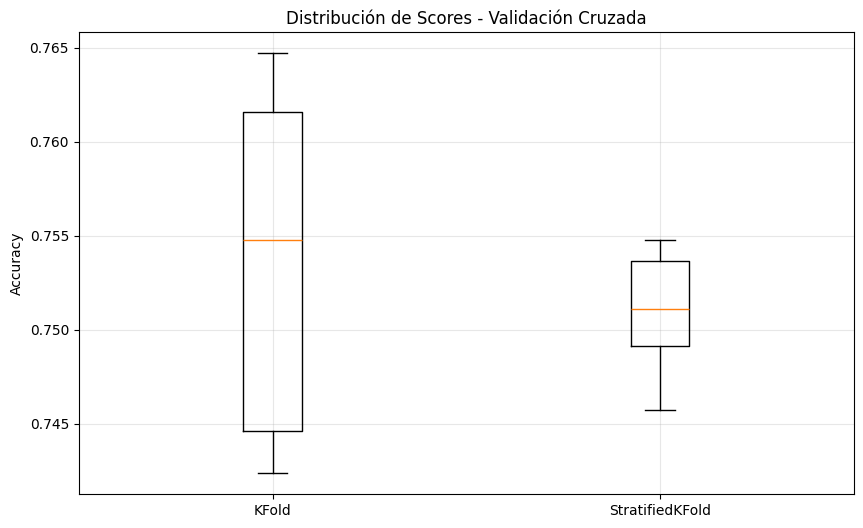

In [ ]:
# 7. Visualizar la distribución de scores
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.boxplot([scores_kfold, scores_stratified], labels=['KFold', 'StratifiedKFold'])
plt.title('Distribución de Scores - Validación Cruzada')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# === COMPETENCIA DE MODELOS ===

print("🏆 TORNEO: ¿Cuál modelo funciona mejor para diagnóstico médico?")

# 1. Definir candidatos (diferentes algoritmos)
models = {
    'Logistic Regression':Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),

    # 2. Ridge Classifier (regresión logística con regularización L2)
    'Ridge Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RidgeClassifier(alpha=1.0, random_state=42))
    ]),

    # 3. Random Forest (ensemble, no necesita escalado)
    'Random Forest': Pipeline([
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}

print(f"Modelos en competencia: {list(models.keys())}")

🏆 TORNEO: ¿Cuál modelo funciona mejor para diagnóstico médico?
Modelos en competencia: ['Logistic Regression', 'Ridge Classifier', 'Random Forest']


In [ ]:
# 4. Evaluar cada modelo con validación cruzada
print(f"\nEVALUANDO MODELOS CON 5-FOLD CV...")

results = {}
for name, model in models.items():
    print(f"   Evaluando {name}...")

    # Usar StratifiedKFold para mantener balance de clases
    scores = cross_val_score(
        model, X_features, y_target,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1_weighted'
    )

    results[name] = scores

    print(f"   {name}: {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"      Scores: {[f'{s:.3f}' for s in scores]}")


EVALUANDO MODELOS CON 5-FOLD CV...
   Evaluando Logistic Regression...
   Logistic Regression: 0.7442 ± 0.0071
      Scores: ['0.748', '0.756', '0.743', '0.735', '0.740']
   Evaluando Ridge Classifier...
   Ridge Classifier: 0.7096 ± 0.0047
      Scores: ['0.716', '0.707', '0.708', '0.703', '0.714']
   Evaluando Random Forest...
   Random Forest: 0.7494 ± 0.0041
      Scores: ['0.755', '0.750', '0.753', '0.745', '0.744']


In [ ]:
# 5. Encontrar el mejor modelo
print(f"\nRESULTADOS FINALES:")

# Encontrar modelo con mayor accuracy promedio
best_mean_score = 0
best_model_name = ""

for name, scores in results.items():
    if scores.mean() > best_mean_score:
        best_mean_score = scores.mean()
        best_model_name = name

print(f"GANADOR: {best_model_name}")
print(f"Score: {best_mean_score:.4f}")

# 6. Análisis detallado de estabilidad
print(f"\nANÁLISIS DE ESTABILIDAD:")
for name, scores in results.items():
    stability = scores.std()

    if stability < 0.02:
        status = "MUY ESTABLE"
    elif stability < 0.05:
        status = "ESTABLE"
    else:
        status = "INESTABLE"

    print(f"   {name}: {status} (std: {stability:.4f})")


RESULTADOS FINALES:
GANADOR: Random Forest
Score: 0.7494

ANÁLISIS DE ESTABILIDAD:
   Logistic Regression: MUY ESTABLE (std: 0.0071)
   Ridge Classifier: MUY ESTABLE (std: 0.0047)
   Random Forest: MUY ESTABLE (std: 0.0041)


/tmp/ipython-input-3124341795.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results[name] for name in models.keys()],


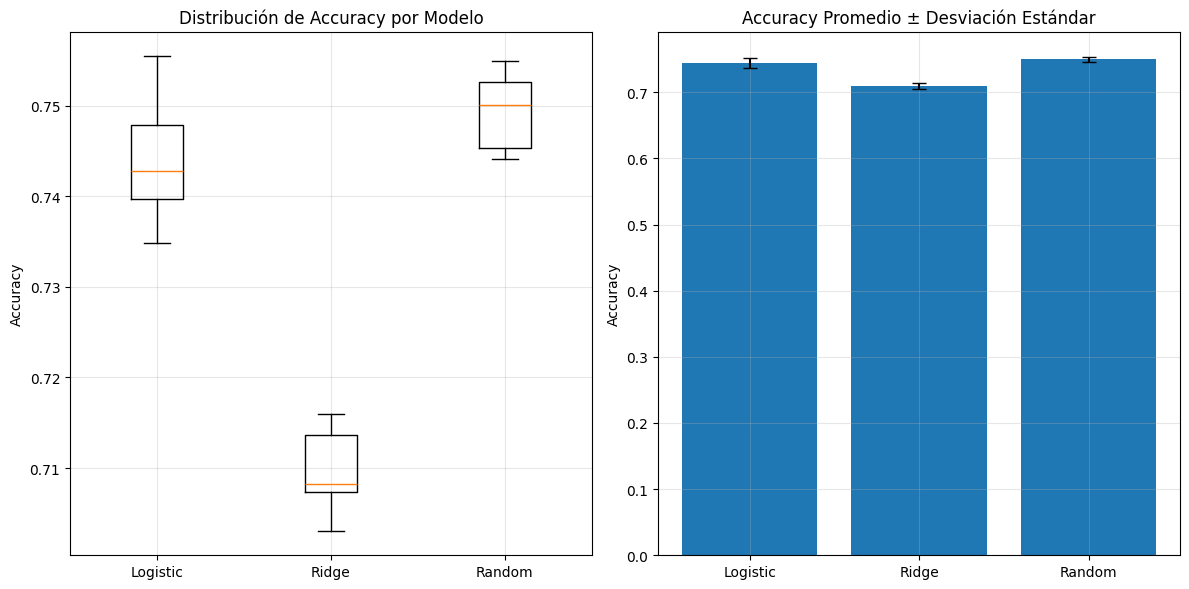

In [ ]:
# 7. Visualización comparativa
plt.figure(figsize=(12, 6))

# Boxplot de distribución de scores
plt.subplot(1, 2, 1)
plt.boxplot([results[name] for name in models.keys()],
           labels=[name.split()[0] for name in models.keys()])
plt.title('Distribución de Accuracy por Modelo')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

# Barplot de medias con error bars
plt.subplot(1, 2, 2)
names = list(models.keys())
means = [results[name].mean() for name in names]
stds = [results[name].std() for name in names]

plt.bar(range(len(names)), means, yerr=stds, capsize=5)
plt.xticks(range(len(names)), [name.split()[0] for name in names])
plt.title('Accuracy Promedio ± Desviación Estándar')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()